In [1]:
import tensorflow as tf
from keras import layers, models
import matplotlib.pyplot as plt

In [2]:
IMGAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train_images",
    shuffle=True,
    image_size = (IMGAGE_SIZE, IMGAGE_SIZE),
    batch_size = BATCH_SIZE,
)

Found 10407 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names
class_names

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

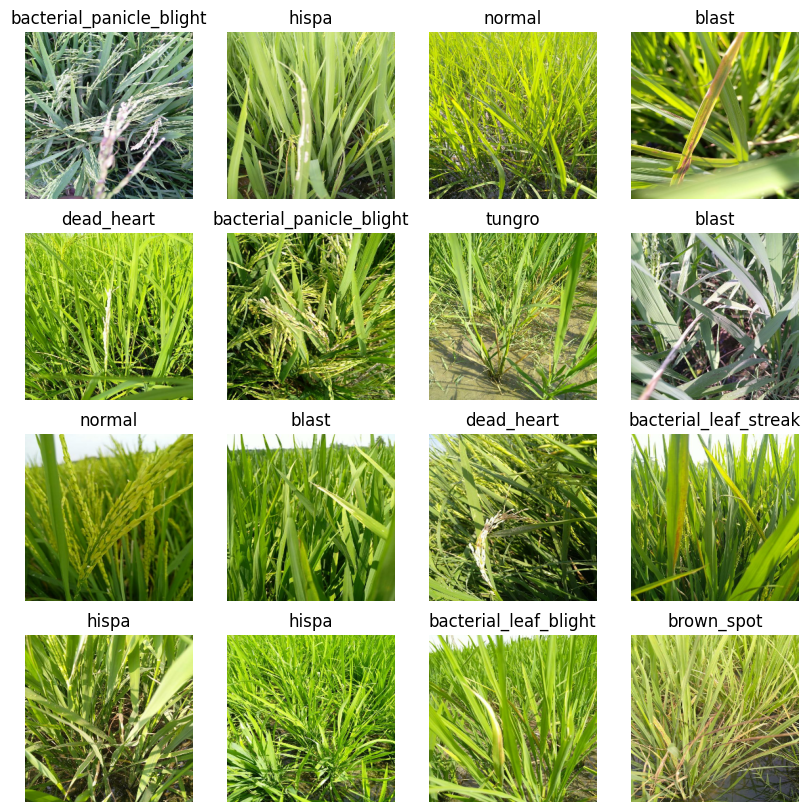

In [5]:
for image_batch, label_batch in dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    plt.show()

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1,test_split = 0.1, shuffle=True, shuffle_size=10000):
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * len(ds))
    val_size = int(val_split * len(ds))
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    return train_ds, val_ds, test_ds

In [7]:
from tensorflow.python.client import device_lib
import tensorflow as tf

# List all physical GPU devices
gpus = tf.config.list_physical_devices('GPU')
print("Available GPU devices:")
for gpu in gpus:
    print(gpu)

# More detailed device info
print("\nDetailed device info:")
print(device_lib.list_local_devices())


Available GPU devices:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

Detailed device info:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2585220477892562239
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5713690624
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2119567274079907012
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [8]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)
len(train_ds), len(val_ds), len(test_ds)

(260, 32, 34)

In [9]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMGAGE_SIZE, IMGAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [10]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [14]:
input_shape = (BATCH_SIZE,IMGAGE_SIZE, IMGAGE_SIZE, CHANNELS)
n_classes = 10
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax')

])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 60, 60, 64)         

In [15]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

Epoch 1/50
260/260 [==============================] - 95s 94ms/step - loss: 1.9136 - accuracy: 0.3292 - val_loss: 1.8998 - val_accuracy: 0.3828
Epoch 2/50
260/260 [==============================] - 22s 74ms/step - loss: 1.5400 - accuracy: 0.4656 - val_loss: 1.8150 - val_accuracy: 0.4014
Epoch 3/50
260/260 [==============================] - 23s 75ms/step - loss: 1.3111 - accuracy: 0.5507 - val_loss: 1.6431 - val_accuracy: 0.4199
Epoch 4/50
260/260 [==============================] - 21s 69ms/step - loss: 1.1449 - accuracy: 0.6066 - val_loss: 0.9012 - val_accuracy: 0.6924
Epoch 5/50
260/260 [==============================] - 21s 70ms/step - loss: 0.9865 - accuracy: 0.6603 - val_loss: 0.6910 - val_accuracy: 0.7900
Epoch 6/50
260/260 [==============================] - 22s 71ms/step - loss: 0.8888 - accuracy: 0.6918 - val_loss: 0.9476 - val_accuracy: 0.6895
Epoch 7/50
260/260 [==============================] - 21s 70ms/step - loss: 0.8030 - accuracy: 0.7180 - val_loss: 0.6861 - val_accuracy:

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

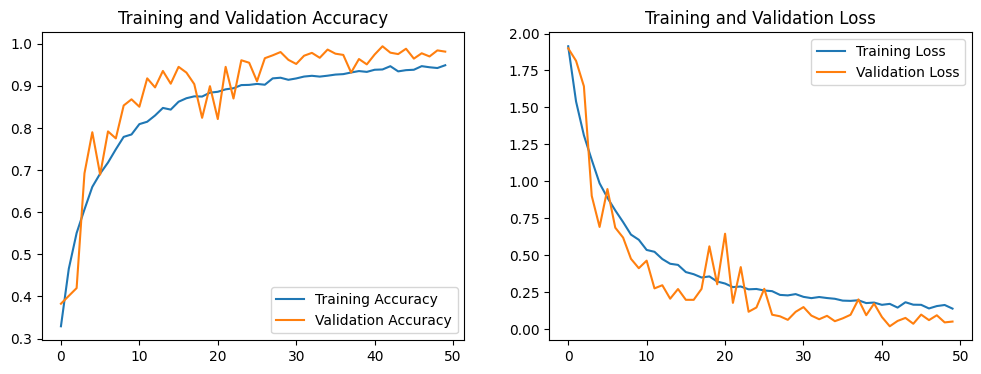

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
from keras.models import load_model 
model.save("network.h5") 

